In [0]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from skimage.filters import threshold_yen
from skimage.exposure import rescale_intensity
from skimage.io import imread, imsave

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def loadImg(path):
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  yen_threshold = threshold_yen(img)
  bright = rescale_intensity(img, (0, yen_threshold), (0, 255))
  return bright
def showImg(img):
  plt.axis("off")
  plt.imshow(img)
  plt.show()
def _hog(img, B):
  gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
  gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
  mag,ang = cv2.cartToPolar(gx, gy)
  bins = np.int32((ang*B)/(2*np.pi))
  bin_cells = bins[:10,:10], bins[10:,:10], bins[:10,10:], bins[10:,10:]
  mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
  hists = [np.bincount(b.ravel(), m.ravel(), B) for b,m in zip(bin_cells, mag_cells)]
  hist = np.hstack(hists)
  return hist
def hog(img, B):
  r = img[:, :, 0]
  g = img[:, :, 1]
  b = img[:, :, 2]
  r = _hog(r, B)
  g = _hog(g, B)
  b = _hog(b, B)
  hist = np.concatenate((r,g,b))
  return hist

In [0]:
pathA = "/content/drive/My Drive/DataSet's/FruitsDB/Apples/"
pathM = "/content/drive/My Drive/DataSet's/FruitsDB/Oranges/"
pathO = "/content/drive/My Drive/DataSet's/FruitsDB/Mangoes/"

In [0]:
train = []
target = []
test = []
test_target = []
classes = ["Apple", "Orange", "Mango"]

In [0]:
for f in listdir(pathA + "Train"):
  path = pathA + "Train/" + f
  img = loadImg(path)
  h = hog(img, 16)
  train.append(h)
  target.append(0)
for f in listdir(pathM + "Train"):
  path = pathM + "Train/" + f
  img = loadImg(path)
  h = hog(img, 16)
  train.append(h)
  target.append(1)
for f in listdir(pathO + "Train"):
  path = pathO + "Train/" + f
  img = loadImg(path)
  h = hog(img, 16)
  train.append(h)
  target.append(2)

for f in listdir(pathA + "Test"):
  path = pathA + "Test/" + f
  img = loadImg(path)
  h = hog(img, 16)
  test.append(h)
  test_target.append(0)
for f in listdir(pathM + "Test"):
  path = pathM + "Test/" + f
  img = loadImg(path)
  h = hog(img, 16)
  test.append(h)
  test_target.append(1)
for f in listdir(pathO + "Test"):
  path = pathO + "Test/" + f
  img = loadImg(path)
  h = hog(img, 16)
  test.append(h)
  test_target.append(2)

In [7]:
test = np.vstack(test)
train = np.vstack(train)
target = np.vstack(target)
test_target = np.vstack(test_target)
train = np.float32(train)
test = np.float32(test)

print(train.shape)
print(target.shape)
print(test.shape)
print(test_target.shape)

(220, 192)
(220, 1)
(66, 192)
(66, 1)


In [8]:
svm = cv2.ml.SVM_create()
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setType(cv2.ml.SVM_C_SVC)
svm.setC(2.67)
svm.setGamma(5.383)

svm.train(train, cv2.ml.ROW_SAMPLE, target)

True

In [9]:
result = svm.predict(test)[1]
mask = (result==test_target)
correct = np.count_nonzero(mask)
print(correct*100.0/result.size)

98.48484848484848


La clase de la imágen es Apple


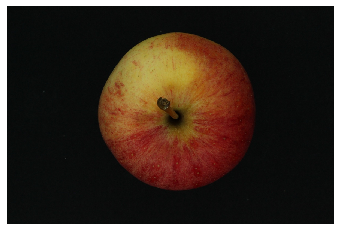

La clase de la imágen es Apple


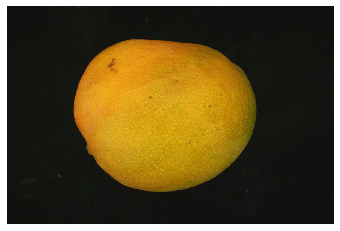

La clase de la imágen es Apple


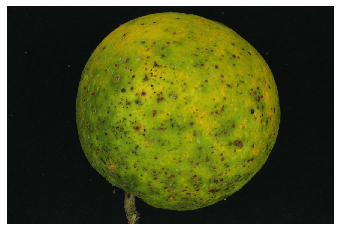

In [11]:
images = ["/content/drive/My Drive/DataSet's/FruitsDB/Apples/Test/Royal_01_1.JPG",
          "/content/drive/My Drive/DataSet's/FruitsDB/Mangoes/Test/Mango_14_A.JPG",
          "/content/drive/My Drive/DataSet's/FruitsDB/Oranges/Test/2013_10_31__0121.jpg"]

for img in images:
  
  img = cv2.imread(img)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  h = hog(img, 16)
  h = np.float32(h)

  result = int( svm.predict(h.reshape(1,192))[1][0][0] )
  result = classes[result]

  print('La clase de la imágen es {}'.format(result))

  showImg(img)